In [1]:
%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("3.0A"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())

original dir:  e:\SUSTech-Battery\data_our_refined\3.0A
changed dir:  e:\SUSTech-Battery\data_our_refined


In [2]:
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from battery_predictor import BatteryPredictor
from battery_dataset import BatteryDataset

cpu


In [3]:
curves4, labels4 = read_data(
    capacity_file="./3.0A/4/capacity.xlsx", curve_file="./3.0A/4/curve.xlsx"
)

# curves5, labels5 = read_data(
#     capacity_file="./3.0A/5/capacity.xlsx", curve_file="./3.0A/5/curve.xlsx"
# )

# curves6, labels6 = read_data(
#     capacity_file="./3.0A/6/capacity.xlsx", curve_file="./3.0A/6/curve.xlsx"
# )

d:\Miniconda3\envs\battery\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Total 893 curves, Total 893 labels
The first curve has 175 data points and 5 stages


In [4]:
CURVES = curves4
LABELS = labels4

In [16]:
delta_t = 30 # s

Vh = 4.2  # V
Vl = 4.0  # V

Ih = 3.0  # A
Il = 0.5  # A

NUM_V = 20
NUM_I = 6

In [21]:
from torch.utils.data import DataLoader


data_X_v, data_X_i, data_y = get_training_data(CURVES, LABELS, NUM_V, NUM_I)

print(f"原始数量    -> {len(CURVES)}")
print(f"训练数量    -> 横流充电电压：{len(data_X_v)}，恒压充电电流：{len(data_X_i)}")
print(
    f"数据长度    -> 横流充电电压：{len(data_X_v[0])}，恒压充电电流：{len(data_X_i[0])}"
)
print(f"采样间隔    -> {delta_t}s")
print(f"CC阶段电流  -> {Ih}A")
print(f"CC阶段电压  -> {Vl}-{Vh}V")
print(f"CV阶段电压  -> {4.2}V")
print(f"CV阶段电流  -> {Ih}-{Il}A")

X = torch.concatenate([torch.tensor(data_X_v), torch.tensor(data_X_i)], dim=1).to(device)
y = torch.tensor(data_y).to(device)


第681组数据的电压数据不足，跳过
第682组数据的电压数据不足，跳过
第683组数据的电压数据不足，跳过
第684组数据的电压数据不足，跳过
第685组数据的电压数据不足，跳过
第686组数据的电压数据不足，跳过
第687组数据的电压数据不足，跳过
第688组数据的电压数据不足，跳过
第689组数据的电压数据不足，跳过
第690组数据的电压数据不足，跳过
--------------------------------------------------
原始数量    -> 893
训练数量    -> 横流充电电压：883，恒压充电电流：883
数据长度    -> 横流充电电压：20，恒压充电电流：6
采样间隔    -> 30s
CC阶段电流  -> 3.0A
CC阶段电压  -> 4.0-4.2V
CV阶段电压  -> 4.2V
CV阶段电流  -> 3.0-0.5A


In [38]:
def normalize_0_1(array):
    min_value = torch.min(array, axis=0)[0]
    max_value = torch.max(array, axis=0)[0]
    normalized_array = (array - min_value) / (max_value - min_value)
    return normalized_array

In [66]:
X_norm = normalize_0_1(X)
y_norm = normalize_0_1(y)

MIN_X = torch.min(X, axis=0)[0].cpu().numpy()
MAX_X = torch.max(X, axis=0)[0].cpu().numpy()

MIN_Y = torch.min(y, axis=0)[0].cpu().numpy()
MAX_Y = torch.max(y, axis=0)[0].cpu().numpy()

print(MIN_X, MAX_X)
print(MIN_Y, MAX_Y)
# X_norm = normalize_zscore(X)
# y_norm = normalize_zscore(y)
np.save("./3.0A/tmp/MIN_X.npy", MIN_X)
np.save("./3.0A/tmp/MAX_X.npy", MAX_X)
np.save("./3.0A/tmp/MIN_Y.npy", MIN_Y)
np.save("./3.0A/tmp/MAX_Y.npy", MAX_Y)

[3.9264 3.938  3.95   3.9623 3.9748 3.9874 4.0003 4.0134 3.9716 4.0404
 4.0544 4.0688 4.0835 4.0986 4.1143 4.1304 4.1471 4.1643 4.1821 4.2
 2.9711 2.3831 2.     1.6937 1.4415 1.2294] [3.9859 3.9976 4.0095 4.0215 4.0336 4.0459 4.0582 4.0705 4.083  4.0954
 4.1079 4.1203 4.1326 4.1448 4.1567 4.1682 4.179  4.1895 4.2    4.2001
 3.0009 2.7303 2.5387 2.3704 2.2165 2.0743]
1.571 2.0278


In [53]:
BAT_SIZE = 16
dataset = BatteryDataset(X_norm, y_norm)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# 将训练集分为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [56]:
predictor = BatteryPredictor(input_len=X.shape[1]).to(device)
loss_list = []


模型训练

In [57]:
from tqdm import tqdm

predictor.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

for epoch in range(300):
    tqdm_dataloader = tqdm(
        train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True
    )
    for batch_X, batch_y in tqdm_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X.float())

        loss = criterion(output, batch_y.float().unsqueeze(1))
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_dataloader.set_postfix(loss=loss.item())

print("训练完成")

Epoch 133:  58%|█████▊    | 26/45 [00:00<00:00, 185.35it/s, loss=0.00113] 


KeyboardInterrupt: 

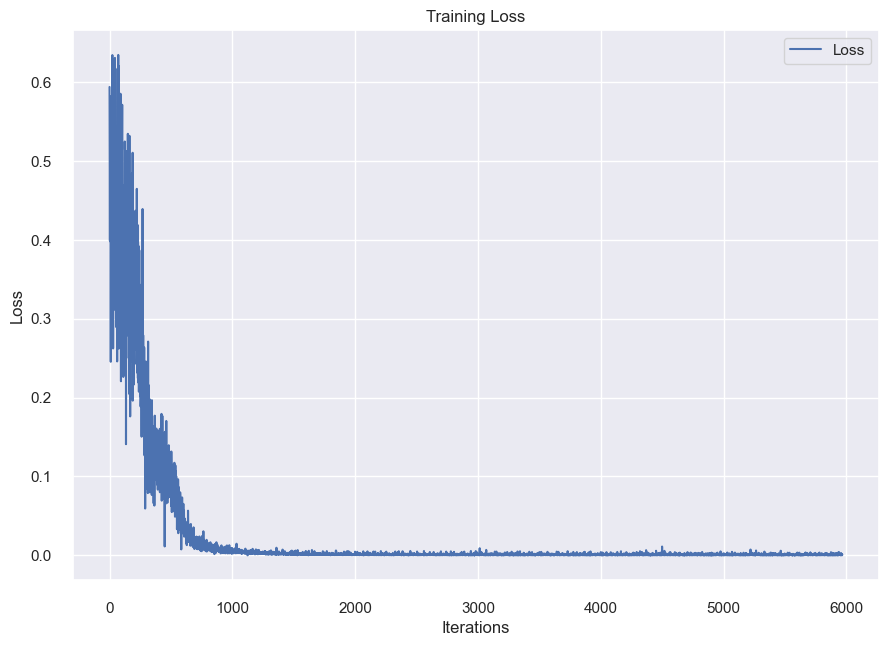

In [58]:
plt.figure()
plt.plot(loss_list, label="Loss")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

模型评估

In [59]:
predictor.eval()

def plot_predictions_dataloader(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(list(range(1, len(y_true)+1)), y_true, label="True")
    plt.scatter(list(range(1, len(y_pred)+1)), y_pred, label="Predicted", color="orange", s=2)
    plt.title("Predictions of Capacity", fontsize=18)
    plt.xlabel("Cycle", fontsize=16)
    plt.ylabel("Capacity (mAh)", fontsize=16)
    plt.legend()
    plt.show()

In [60]:
y_pred = []
with torch.no_grad():
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        y_pred.extend(output.cpu().numpy())

y_pred = np.array(y_pred).flatten() * (MAX_Y - MIN_Y) + MIN_Y

y_true = y.cpu().numpy()

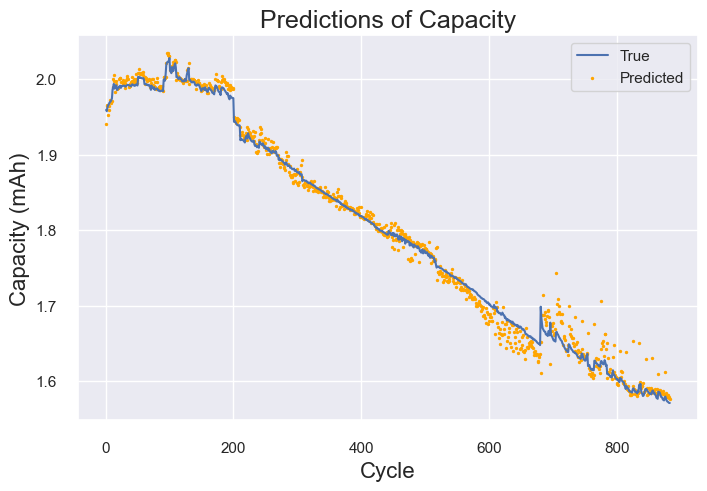

In [61]:
plot_predictions_dataloader(y_true, y_pred)

In [62]:
# Metrics
from sklearn.metrics import root_mean_squared_error


def calculate_metrics(predictor, dataloader, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X)
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    y_true = y_true * (MAX_Y - MIN_Y) + MIN_Y
    y_pred = y_pred * (MAX_Y - MIN_Y) + MIN_Y

    rmse = root_mean_squared_error(y_true, y_pred)
    mre = np.mean(np.abs((y_true - y_pred) / y_true))
    return rmse, mre


rmse_train, mre_train = calculate_metrics(predictor, train_dataloader, device)

print("Training Metrics")
print(f"RMSE: {rmse_train:.4f}")
print(f"MRE: {mre_train:.4f}")

rmse_val, mre_val = calculate_metrics(predictor, val_dataloader, device)

print("Validation Metrics")
print(f"RMSE: {rmse_val:.4f}")
print(f"MRE: {mre_val:.4f}")

Training Metrics
RMSE: 0.0135
MRE: 0.0051
Validation Metrics
RMSE: 0.0129
MRE: 0.0052


保存模型

In [63]:
path = "./3.0A/battery_predictor-3A.pth"
torch.save(predictor.state_dict(), path)
print(f"模型已保存到 {path}")

模型已保存到 ./3.0A/battery_predictor-3A.pth
